# 1) simple LSTM on Sine wave:
- `Long Short Term Memory (LSTM)`

<img src="./pictures/LSTM_cell_01.png"
     style="float: left; margin-right: 10px; width: 500px"/>

In [1]:
# basic libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tensorflow:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Sklearn:
from sklearn.preprocessing import MinMaxScaler

In [2]:
# creating data:
X_inp = np.linspace(start=0, stop=50, num=501)
y_out = np.sin(X_inp)

In [3]:
# shape of previous data:
print("shape of X_inp: ", X_inp.shape)
print("shape of y_out: ", y_out.shape)

shape of X_inp:  (501,)
shape of y_out:  (501,)


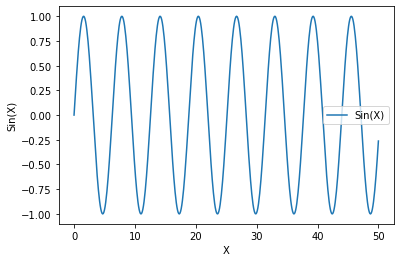

In [4]:
# plotting our data:
plt.plot(X_inp, y_out)
plt.xlabel("X")
plt.ylabel("Sin(X)")
plt.legend(["Sin(X)"])
plt.show()

In [5]:
# converting data to DataFrame:
df = pd.DataFrame(data=y_out, index=X_inp, columns=["Sin(X)"])
df

,Sin(X)
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418
...,...
49.6,-0.617439
49.7,-0.535823
49.8,-0.448854
49.9,-0.357400


In [6]:
# trian / test split:
x_test_per = 0.1
x_test_number = np.round(len(df)*0.1)
x_test_index_s = int(len(df) - x_test_number)

In [7]:
# defining x_train / x_test:
x_train = df.iloc[:x_test_index_s]
x_test = df.iloc[x_test_index_s:]

In [8]:
# preprocessing data using MinMaxScaler()
MinMax_scaler = MinMaxScaler()
MinMax_scaler.fit(x_train)

# scaled vesrion of x_train:
x_train_scaled = MinMax_scaler.transform(x_train)
# scaled version of x_test:
x_test_scaled = MinMax_scaler.transform(x_test)

In [9]:
# EarlyStopping:
early_stop = EarlyStopping(monitor="val_loss",
                           patience=2)

In [10]:
# converting data to time series using TimeseriesGenerator:
# for both train & test data:
# for train data:
sequence_length = 50
batch_size= 1
number_of_features = 1

# for train data:
TimeSeries_gen_train = TimeseriesGenerator(data=x_train_scaled,
                                           targets=x_train_scaled,
                                           length=sequence_length,
                                           batch_size=batch_size)
# for test data:
sequence_length_test = 49
TimeSeries_gen_test = TimeseriesGenerator(data=x_test_scaled,
                                          targets=x_test_scaled,
                                          length=sequence_length_test,
                                          batch_size=batch_size)

In [11]:
# creating LSTM model:
lstm_model = Sequential()

# LSTM cell:
lstm_model.add(LSTM(50,
               input_shape=(sequence_length, number_of_features)))
# output:
lstm_model.add(Dense(1))

# compiling:
lstm_model.compile(optimizer="adam",
                   loss="mse")

In [12]:
# summary of the model:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [13]:
# fitting the model:
lstm_model.fit(TimeSeries_gen_train,
              epochs=20,
              validation_data = TimeSeries_gen_test,
              callbacks=[early_stop])

Epoch 1/20
401/401 [==============================] - 12s 23ms/step - loss: 0.0110 - val_loss: 2.6476e-05
Epoch 2/20
401/401 [==============================] - 9s 21ms/step - loss: 1.1938e-04 - val_loss: 7.4554e-06
Epoch 3/20
401/401 [==============================] - 9s 22ms/step - loss: 1.8794e-04 - val_loss: 7.0064e-05
Epoch 4/20
401/401 [==============================] - 9s 22ms/step - loss: 1.7146e-04 - val_loss: 4.5440e-05


In [14]:
# saving the model into (saved_model folder)
lstm_model.save("..\\simple LSTM\\saved_model\\sine_wave_predictor_lstm.h5")

In [15]:
# creating a DataFrame for losses:
losses = pd.DataFrame(data=lstm_model.history.history)
losses

,loss,val_loss
0,0.010973,0.000026
1,0.000119,0.000007
2,0.000188,0.000070
3,0.000171,0.000045


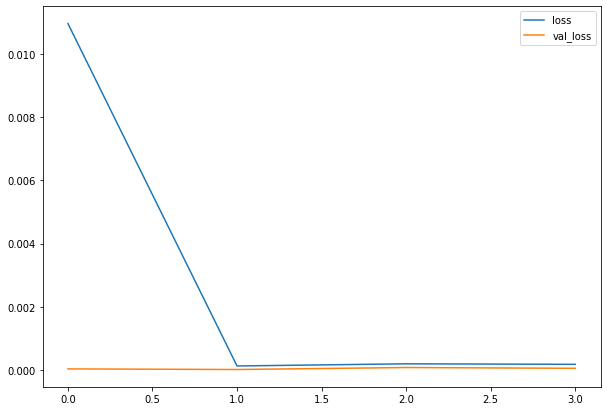

In [16]:
# plotting losses:
losses[["loss", "val_loss"]].plot(figsize=(10,7))
plt.show()

In [17]:
# evaluation on test:
test_predictions = []
first_eval_batch = x_train_scaled[-sequence_length:]
current_batch = first_eval_batch.reshape((1, sequence_length, number_of_features))

for i in range(len(x_test)):
    current_pred = lstm_model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, ], [[current_pred]], axis=1)

e:\app_special\anaconda_onwin\envs\mytfenv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


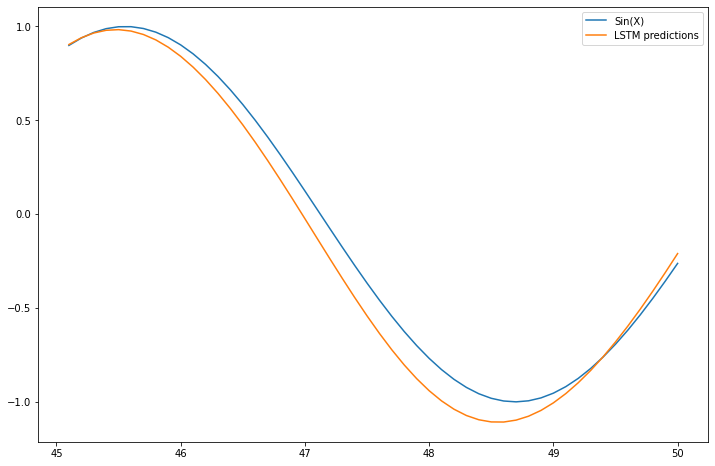

In [18]:
# plotting true and predictions:
true_predictions = MinMax_scaler.inverse_transform(test_predictions)
x_test["LSTM predictions"] = true_predictions
x_test.plot(figsize=(12,8))
plt.show()

# The End